# 1. Build your own convolutional neural network using pytorch

In [8]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.query_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)
        value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Output: 224x224x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 112x112x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 112x112x128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 56x56x128

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Output: 56x56x256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 28x28x256

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Output: 28x28x512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),  # Output: 28x28x1024
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 14x14x1024
        )
        
        self.attention = AttentionBlock(1024)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, num_classes)

        # Dropout and activation
        self.dropout = nn.Dropout(p=0.5)
        self.additional_dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.attention(x)
        x = self.flatten(x)

        # Fully connected layers with dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.additional_dropout(x)

        x = self.fc4(x)  # Output layer
        return x


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [11]:
class TestDataSet(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(img_path)
        return image, filename

In [12]:
test_transform = test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a slightly larger size first
    transforms.RandomCrop((224, 224)),  # Randomly crop to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [13]:
batch_size = 64

In [15]:

# Load train and validation datasets
train_dataset = datasets.ImageFolder(root='./dataset/Train', transform=transform)
val_dataset = datasets.ImageFolder(root='./dataset/Valid', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [16]:
# Load the test dataset
test_dataset = TestDataSet(root_dir='./dataset/Test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Print number of samples in each dataset
print(f"Number of samples in the training dataset: {len(train_dataset)}")
print(f"Number of samples in the validation dataset: {len(val_dataset)}")
print(f"Number of samples in the test dataset: {len(test_dataset)}")

# Print number of batches in each DataLoader
print(f"Number of batches in the training DataLoader: {len(train_loader)}")
print(f"Number of batches in the validation DataLoader: {len(val_loader)}")
print(f"Number of batches in the test DataLoader: {len(test_loader)}")


Number of samples in the training dataset: 1400
Number of samples in the validation dataset: 200
Number of samples in the test dataset: 400
Number of batches in the training DataLoader: 22
Number of batches in the validation DataLoader: 4
Number of batches in the test DataLoader: 7


In [10]:
from datetime import datetime

# Format the timestamp without spaces or dashes (e.g., YYYYMMDD_HHMMSS)
formatted_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

formatted_timestamp


'20241116_182233'

In [18]:
torch.cuda.empty_cache()

In [19]:
num_classes = len(train_dataset.classes) 
model = CustomCNN(num_classes=num_classes).to(device)

In [13]:
num_epochs = 200
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001,weight_decay=0.01)  # Add weight decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

In [15]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store training and validation losses and accuracies
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Initialize best validation loss and accuracy to keep track of improvements
best_val_loss = float('inf')
best_val_accuracy = 0.0

validate_every_n_epochs = 1  # Validate every 'n' epochs (adjust as needed)

# Training loop with loss logging
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    # Training loop with tqdm for progress bar
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass and compute loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

    # Calculate and store average training loss and accuracy for the epoch
    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)
    training_accuracy = correct_train_predictions / total_train_predictions
    training_accuracies.append(training_accuracy)

    # Validate every `validate_every_n_epochs`
    if (epoch + 1) % validate_every_n_epochs == 0:
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        all_labels = []
        all_predictions = []

        # Validation loop with tqdm for progress bar
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}", leave=False):
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)

                # Calculate validation loss
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                # Get the predicted class by finding the index with the maximum output value
                _, predicted = torch.max(val_outputs, 1)

                # Collect predictions and labels for metrics calculation
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                # Update the total predictions and correct predictions
                total_predictions += val_labels.size(0)
                correct_predictions += (predicted == val_labels).sum().item()

        # Calculate metrics
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        val_accuracy = correct_predictions / total_predictions

        # Calculate and store average validation loss and accuracy for the epoch
        avg_val_loss = val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        validation_accuracies.append(val_accuracy)

       # Print metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {training_loss:.4f}, Training Accuracy: {(training_accuracy*100):.2f} %")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {(val_accuracy*100):.2f} %")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Update best validation loss and accuracy and save the model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'bm_by_loss_{formatted_timestamp}.pth')
            print("Saved new best model by validation loss!")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'bm_by_accuracy_{formatted_timestamp}.pth')
            print("Saved new best model by validation accuracy!")



Epoch [1/200], Training Loss: 1.6249, Training Accuracy: 40.36 %
Validation Loss: 1.0619, Validation Accuracy: 45.00 %
Precision: 0.2058, Recall: 0.4500, F1 Score: 0.2824
Saved new best model by validation loss!
Saved new best model by validation accuracy!


Epoch [2/200], Training Loss: 1.2429, Training Accuracy: 38.50 %
Validation Loss: 1.0258, Validation Accuracy: 39.00 %
Precision: 0.3415, Recall: 0.3900, F1 Score: 0.2788
Saved new best model by validation loss!


Epoch [3/200], Training Loss: 1.0827, Training Accuracy: 41.57 %
Validation Loss: 1.0305, Validation Accuracy: 44.00 %
Precision: 0.3581, Recall: 0.4400, F1 Score: 0.3865


Epoch [4/200], Training Loss: 1.0458, Training Accuracy: 41.29 %
Validation Loss: 0.9958, Validation Accuracy: 46.50 %
Precision: 0.4460, Recall: 0.4650, F1 Score: 0.3282
Saved new best model by validation loss!
Saved new best model by validation accuracy!


Epoch [5/200], Training Loss: 1.0111, Training Accuracy: 44.57 %
Validation Loss: 0.9624, Validation Accuracy: 42.00 %
Precision: 0.3488, Recall: 0.4200, F1 Score: 0.3803
Saved new best model by validation loss!


Epoch [6/200], Training Loss: 1.0137, Training Accuracy: 43.14 %
Validation Loss: 0.9762, Validation Accuracy: 41.00 %
Precision: 0.2832, Recall: 0.4100, F1 Score: 0.2993


Epoch [7/200], Training Loss: 0.9688, Training Accuracy: 43.71 %
Validation Loss: 0.9434, Validation Accuracy: 45.00 %
Precision: 0.5158, Recall: 0.4500, F1 Score: 0.3724
Saved new best model by validation loss!


Epoch [8/200], Training Loss: 0.9468, Training Accuracy: 44.00 %
Validation Loss: 0.9230, Validation Accuracy: 51.00 %
Precision: 0.5462, Recall: 0.5100, F1 Score: 0.4622
Saved new best model by validation loss!
Saved new best model by validation accuracy!


Epoch [9/200], Training Loss: 0.9318, Training Accuracy: 47.07 %
Validation Loss: 0.9366, Validation Accuracy: 50.50 %
Precision: 0.5158, Recall: 0.5050, F1 Score: 0.4672


Epoch [10/200], Training Loss: 0.9011, Training Accuracy: 47.29 %
Validation Loss: 0.8770, Validation Accuracy: 57.50 %
Precision: 0.5762, Recall: 0.5750, F1 Score: 0.5674
Saved new best model by validation loss!
Saved new best model by validation accuracy!


Epoch [11/200], Training Loss: 0.8855, Training Accuracy: 50.64 %
Validation Loss: 0.8773, Validation Accuracy: 50.50 %
Precision: 0.5882, Recall: 0.5050, F1 Score: 0.4058


Epoch [12/200], Training Loss: 0.8431, Training Accuracy: 53.00 %
Validation Loss: 0.8613, Validation Accuracy: 51.50 %
Precision: 0.5109, Recall: 0.5150, F1 Score: 0.4846
Saved new best model by validation loss!


Epoch [13/200], Training Loss: 0.8203, Training Accuracy: 54.71 %
Validation Loss: 0.7807, Validation Accuracy: 54.00 %
Precision: 0.5375, Recall: 0.5400, F1 Score: 0.5355
Saved new best model by validation loss!


Epoch [14/200], Training Loss: 0.8224, Training Accuracy: 55.50 %
Validation Loss: 0.8844, Validation Accuracy: 60.00 %
Precision: 0.6354, Recall: 0.6000, F1 Score: 0.5723
Saved new best model by validation accuracy!


Epoch [15/200], Training Loss: 0.8181, Training Accuracy: 55.86 %
Validation Loss: 0.8075, Validation Accuracy: 60.00 %
Precision: 0.6149, Recall: 0.6000, F1 Score: 0.5806


Epoch [16/200], Training Loss: 0.7803, Training Accuracy: 57.71 %
Validation Loss: 0.7123, Validation Accuracy: 66.50 %
Precision: 0.6815, Recall: 0.6650, F1 Score: 0.6489
Saved new best model by validation loss!
Saved new best model by validation accuracy!


Epoch [17/200], Training Loss: 0.7673, Training Accuracy: 58.50 %
Validation Loss: 0.7165, Validation Accuracy: 64.50 %
Precision: 0.6571, Recall: 0.6450, F1 Score: 0.6347


Epoch [18/200], Training Loss: 0.7518, Training Accuracy: 60.14 %
Validation Loss: 0.7469, Validation Accuracy: 65.50 %
Precision: 0.6700, Recall: 0.6550, F1 Score: 0.6422


Epoch [19/200], Training Loss: 0.7482, Training Accuracy: 60.93 %
Validation Loss: 0.6752, Validation Accuracy: 64.00 %
Precision: 0.6627, Recall: 0.6400, F1 Score: 0.6130
Saved new best model by validation loss!


Epoch [20/200], Training Loss: 0.7467, Training Accuracy: 59.57 %
Validation Loss: 0.8167, Validation Accuracy: 57.50 %
Precision: 0.5884, Recall: 0.5750, F1 Score: 0.5490


Epoch [21/200], Training Loss: 0.7416, Training Accuracy: 59.57 %
Validation Loss: 0.7764, Validation Accuracy: 61.50 %
Precision: 0.6790, Recall: 0.6150, F1 Score: 0.5637


Epoch [22/200], Training Loss: 0.7432, Training Accuracy: 59.64 %
Validation Loss: 0.6798, Validation Accuracy: 63.00 %
Precision: 0.6480, Recall: 0.6300, F1 Score: 0.6065


Epoch [23/200], Training Loss: 0.7160, Training Accuracy: 63.36 %
Validation Loss: 0.7252, Validation Accuracy: 61.00 %
Precision: 0.6140, Recall: 0.6100, F1 Score: 0.6041


Epoch [24/200], Training Loss: 0.7263, Training Accuracy: 62.64 %
Validation Loss: 0.7806, Validation Accuracy: 63.50 %
Precision: 0.6664, Recall: 0.6350, F1 Score: 0.6033


Epoch [25/200], Training Loss: 0.7205, Training Accuracy: 61.64 %
Validation Loss: 0.6476, Validation Accuracy: 63.00 %
Precision: 0.6678, Recall: 0.6300, F1 Score: 0.5951
Saved new best model by validation loss!


Epoch [26/200], Training Loss: 0.7168, Training Accuracy: 63.21 %
Validation Loss: 0.7196, Validation Accuracy: 59.00 %
Precision: 0.5905, Recall: 0.5900, F1 Score: 0.5645


Epoch [27/200], Training Loss: 0.7045, Training Accuracy: 65.93 %
Validation Loss: 0.7792, Validation Accuracy: 67.50 %
Precision: 0.7182, Recall: 0.6750, F1 Score: 0.6576
Saved new best model by validation accuracy!


Epoch [28/200], Training Loss: 0.6939, Training Accuracy: 62.86 %
Validation Loss: 0.6556, Validation Accuracy: 68.00 %
Precision: 0.6797, Recall: 0.6800, F1 Score: 0.6740
Saved new best model by validation accuracy!


Epoch [29/200], Training Loss: 0.6893, Training Accuracy: 64.79 %
Validation Loss: 0.6594, Validation Accuracy: 68.00 %
Precision: 0.6897, Recall: 0.6800, F1 Score: 0.6747


Epoch [30/200], Training Loss: 0.6814, Training Accuracy: 63.64 %
Validation Loss: 0.6719, Validation Accuracy: 63.00 %
Precision: 0.6477, Recall: 0.6300, F1 Score: 0.6035


Epoch [31/200], Training Loss: 0.6660, Training Accuracy: 67.07 %
Validation Loss: 0.6594, Validation Accuracy: 58.50 %
Precision: 0.5883, Recall: 0.5850, F1 Score: 0.5620


Epoch [32/200], Training Loss: 0.6931, Training Accuracy: 65.36 %
Validation Loss: 0.6689, Validation Accuracy: 61.50 %
Precision: 0.6216, Recall: 0.6150, F1 Score: 0.5894


Epoch [33/200], Training Loss: 0.6935, Training Accuracy: 65.00 %
Validation Loss: 0.6552, Validation Accuracy: 66.50 %
Precision: 0.7103, Recall: 0.6650, F1 Score: 0.6325


Epoch [34/200], Training Loss: 0.6577, Training Accuracy: 67.07 %
Validation Loss: 0.6337, Validation Accuracy: 68.50 %
Precision: 0.6985, Recall: 0.6850, F1 Score: 0.6711
Saved new best model by validation loss!
Saved new best model by validation accuracy!


Epoch [35/200], Training Loss: 0.6632, Training Accuracy: 66.79 %
Validation Loss: 0.6754, Validation Accuracy: 67.00 %
Precision: 0.6670, Recall: 0.6700, F1 Score: 0.6664


Epoch [36/200], Training Loss: 0.6536, Training Accuracy: 66.36 %
Validation Loss: 0.6811, Validation Accuracy: 66.00 %
Precision: 0.6610, Recall: 0.6600, F1 Score: 0.6502


Epoch [37/200], Training Loss: 0.6547, Training Accuracy: 67.36 %
Validation Loss: 0.7762, Validation Accuracy: 67.50 %
Precision: 0.6809, Recall: 0.6750, F1 Score: 0.6684


Epoch [38/200], Training Loss: 0.6415, Training Accuracy: 69.21 %
Validation Loss: 0.6381, Validation Accuracy: 69.00 %
Precision: 0.6866, Recall: 0.6900, F1 Score: 0.6863
Saved new best model by validation accuracy!


Epoch [39/200], Training Loss: 0.6260, Training Accuracy: 69.36 %
Validation Loss: 0.6693, Validation Accuracy: 65.00 %
Precision: 0.6620, Recall: 0.6500, F1 Score: 0.6349


Epoch [40/200], Training Loss: 0.6332, Training Accuracy: 67.29 %
Validation Loss: 0.6555, Validation Accuracy: 64.00 %
Precision: 0.6384, Recall: 0.6400, F1 Score: 0.6386


Epoch [41/200], Training Loss: 0.6346, Training Accuracy: 69.36 %
Validation Loss: 0.7031, Validation Accuracy: 61.50 %
Precision: 0.6177, Recall: 0.6150, F1 Score: 0.6096


Epoch [42/200], Training Loss: 0.6242, Training Accuracy: 68.86 %
Validation Loss: 0.6724, Validation Accuracy: 64.50 %
Precision: 0.6664, Recall: 0.6450, F1 Score: 0.6240


Epoch [43/200], Training Loss: 0.6153, Training Accuracy: 68.50 %
Validation Loss: 0.6164, Validation Accuracy: 66.50 %
Precision: 0.6651, Recall: 0.6650, F1 Score: 0.6606
Saved new best model by validation loss!


Epoch [44/200], Training Loss: 0.6108, Training Accuracy: 71.00 %
Validation Loss: 0.6483, Validation Accuracy: 65.50 %
Precision: 0.6590, Recall: 0.6550, F1 Score: 0.6477


Epoch [45/200], Training Loss: 0.6126, Training Accuracy: 69.64 %
Validation Loss: 0.7844, Validation Accuracy: 64.00 %
Precision: 0.6449, Recall: 0.6400, F1 Score: 0.6280


Epoch [46/200], Training Loss: 0.5893, Training Accuracy: 71.36 %
Validation Loss: 0.6748, Validation Accuracy: 66.00 %
Precision: 0.6718, Recall: 0.6600, F1 Score: 0.6491


Epoch [47/200], Training Loss: 0.6017, Training Accuracy: 70.07 %
Validation Loss: 0.6239, Validation Accuracy: 66.00 %
Precision: 0.6658, Recall: 0.6600, F1 Score: 0.6468


Epoch [48/200], Training Loss: 0.6023, Training Accuracy: 70.71 %
Validation Loss: 0.8749, Validation Accuracy: 65.00 %
Precision: 0.6720, Recall: 0.6500, F1 Score: 0.6254


Epoch [49/200], Training Loss: 0.6134, Training Accuracy: 69.14 %
Validation Loss: 0.6461, Validation Accuracy: 64.00 %
Precision: 0.6536, Recall: 0.6400, F1 Score: 0.6210


Epoch [50/200], Training Loss: 0.6057, Training Accuracy: 71.14 %
Validation Loss: 0.7246, Validation Accuracy: 61.00 %
Precision: 0.6100, Recall: 0.6100, F1 Score: 0.5955


Epoch [51/200], Training Loss: 0.5902, Training Accuracy: 71.86 %
Validation Loss: 0.6106, Validation Accuracy: 66.50 %
Precision: 0.6876, Recall: 0.6650, F1 Score: 0.6439
Saved new best model by validation loss!


Epoch [52/200], Training Loss: 0.5957, Training Accuracy: 69.79 %
Validation Loss: 0.6421, Validation Accuracy: 69.50 %
Precision: 0.6972, Recall: 0.6950, F1 Score: 0.6908
Saved new best model by validation accuracy!


Epoch [53/200], Training Loss: 0.5851, Training Accuracy: 71.57 %
Validation Loss: 0.6407, Validation Accuracy: 69.00 %
Precision: 0.6879, Recall: 0.6900, F1 Score: 0.6870


Epoch [54/200], Training Loss: 0.5825, Training Accuracy: 71.36 %
Validation Loss: 0.6162, Validation Accuracy: 69.00 %
Precision: 0.6891, Recall: 0.6900, F1 Score: 0.6844


Epoch [55/200], Training Loss: 0.5695, Training Accuracy: 72.21 %
Validation Loss: 0.8243, Validation Accuracy: 69.00 %
Precision: 0.6918, Recall: 0.6900, F1 Score: 0.6836


Epoch [56/200], Training Loss: 0.5560, Training Accuracy: 75.43 %
Validation Loss: 0.6002, Validation Accuracy: 63.50 %
Precision: 0.6403, Recall: 0.6350, F1 Score: 0.6269
Saved new best model by validation loss!


Epoch [57/200], Training Loss: 0.5649, Training Accuracy: 72.86 %
Validation Loss: 0.6271, Validation Accuracy: 67.50 %
Precision: 0.6774, Recall: 0.6750, F1 Score: 0.6667


Epoch [58/200], Training Loss: 0.5730, Training Accuracy: 72.07 %
Validation Loss: 0.6401, Validation Accuracy: 69.00 %
Precision: 0.6894, Recall: 0.6900, F1 Score: 0.6869


Epoch [59/200], Training Loss: 0.5655, Training Accuracy: 72.64 %
Validation Loss: 0.5771, Validation Accuracy: 65.50 %
Precision: 0.6616, Recall: 0.6550, F1 Score: 0.6434
Saved new best model by validation loss!


Epoch [60/200], Training Loss: 0.5647, Training Accuracy: 73.71 %
Validation Loss: 0.5507, Validation Accuracy: 72.00 %
Precision: 0.7325, Recall: 0.7200, F1 Score: 0.7108
Saved new best model by validation loss!
Saved new best model by validation accuracy!


Epoch [61/200], Training Loss: 0.5446, Training Accuracy: 74.50 %
Validation Loss: 0.6716, Validation Accuracy: 63.50 %
Precision: 0.6326, Recall: 0.6350, F1 Score: 0.6318


Epoch [62/200], Training Loss: 0.5755, Training Accuracy: 73.64 %
Validation Loss: 0.6975, Validation Accuracy: 67.50 %
Precision: 0.6797, Recall: 0.6750, F1 Score: 0.6640


Epoch [63/200], Training Loss: 0.5775, Training Accuracy: 72.57 %
Validation Loss: 0.5554, Validation Accuracy: 64.00 %
Precision: 0.6457, Recall: 0.6400, F1 Score: 0.6274


Epoch [64/200], Training Loss: 0.5412, Training Accuracy: 73.57 %
Validation Loss: 0.6444, Validation Accuracy: 72.00 %
Precision: 0.7176, Recall: 0.7200, F1 Score: 0.7174


Epoch [65/200], Training Loss: 0.5597, Training Accuracy: 74.57 %
Validation Loss: 0.6646, Validation Accuracy: 65.50 %
Precision: 0.6612, Recall: 0.6550, F1 Score: 0.6505


Epoch [66/200], Training Loss: 0.5638, Training Accuracy: 73.64 %
Validation Loss: 0.6871, Validation Accuracy: 67.50 %
Precision: 0.6715, Recall: 0.6750, F1 Score: 0.6704


Epoch [67/200], Training Loss: 0.5424, Training Accuracy: 74.71 %
Validation Loss: 0.6853, Validation Accuracy: 64.00 %
Precision: 0.6443, Recall: 0.6400, F1 Score: 0.6307


Epoch [68/200], Training Loss: 0.5384, Training Accuracy: 75.71 %
Validation Loss: 0.7154, Validation Accuracy: 62.50 %
Precision: 0.6680, Recall: 0.6250, F1 Score: 0.5843


Epoch [69/200], Training Loss: 0.5494, Training Accuracy: 73.50 %
Validation Loss: 0.6036, Validation Accuracy: 71.00 %
Precision: 0.7226, Recall: 0.7100, F1 Score: 0.7010


Epoch [70/200], Training Loss: 0.5452, Training Accuracy: 75.00 %
Validation Loss: 0.5726, Validation Accuracy: 68.00 %
Precision: 0.6845, Recall: 0.6800, F1 Score: 0.6769


Epoch [71/200], Training Loss: 0.5118, Training Accuracy: 74.43 %
Validation Loss: 0.5529, Validation Accuracy: 74.00 %
Precision: 0.7380, Recall: 0.7400, F1 Score: 0.7369
Saved new best model by validation accuracy!


Epoch [72/200], Training Loss: 0.5240, Training Accuracy: 75.29 %
Validation Loss: 0.7740, Validation Accuracy: 66.00 %
Precision: 0.6603, Recall: 0.6600, F1 Score: 0.6516


Epoch [73/200], Training Loss: 0.5386, Training Accuracy: 75.50 %
Validation Loss: 0.8280, Validation Accuracy: 63.00 %
Precision: 0.6427, Recall: 0.6300, F1 Score: 0.6159


Epoch [74/200], Training Loss: 0.5083, Training Accuracy: 77.00 %
Validation Loss: 0.6340, Validation Accuracy: 65.00 %
Precision: 0.6579, Recall: 0.6500, F1 Score: 0.6379


Epoch [75/200], Training Loss: 0.5332, Training Accuracy: 75.14 %
Validation Loss: 0.6056, Validation Accuracy: 69.00 %
Precision: 0.6942, Recall: 0.6900, F1 Score: 0.6816


Epoch [76/200], Training Loss: 0.5268, Training Accuracy: 75.36 %
Validation Loss: 0.6604, Validation Accuracy: 69.00 %
Precision: 0.6996, Recall: 0.6900, F1 Score: 0.6801


Epoch [77/200], Training Loss: 0.4798, Training Accuracy: 78.14 %
Validation Loss: 0.6669, Validation Accuracy: 71.00 %
Precision: 0.7140, Recall: 0.7100, F1 Score: 0.7023


Epoch [78/200], Training Loss: 0.5027, Training Accuracy: 76.36 %
Validation Loss: 0.5976, Validation Accuracy: 67.00 %
Precision: 0.6718, Recall: 0.6700, F1 Score: 0.6664


Epoch [79/200], Training Loss: 0.4985, Training Accuracy: 77.71 %
Validation Loss: 0.5894, Validation Accuracy: 69.50 %
Precision: 0.6944, Recall: 0.6950, F1 Score: 0.6942


Epoch [80/200], Training Loss: 0.5226, Training Accuracy: 75.14 %
Validation Loss: 0.5499, Validation Accuracy: 70.00 %
Precision: 0.7165, Recall: 0.7000, F1 Score: 0.6880
Saved new best model by validation loss!


Epoch [81/200], Training Loss: 0.4816, Training Accuracy: 77.57 %
Validation Loss: 0.6325, Validation Accuracy: 61.00 %
Precision: 0.6125, Recall: 0.6100, F1 Score: 0.6028


Epoch [82/200], Training Loss: 0.4799, Training Accuracy: 77.93 %
Validation Loss: 0.5618, Validation Accuracy: 69.50 %
Precision: 0.7079, Recall: 0.6950, F1 Score: 0.6830


Epoch [83/200], Training Loss: 0.4750, Training Accuracy: 78.79 %
Validation Loss: 0.6213, Validation Accuracy: 69.00 %
Precision: 0.6997, Recall: 0.6900, F1 Score: 0.6835


Epoch [84/200], Training Loss: 0.4639, Training Accuracy: 79.07 %
Validation Loss: 0.5441, Validation Accuracy: 67.50 %
Precision: 0.6747, Recall: 0.6750, F1 Score: 0.6698
Saved new best model by validation loss!


Epoch [85/200], Training Loss: 0.4809, Training Accuracy: 77.86 %
Validation Loss: 0.7233, Validation Accuracy: 71.50 %
Precision: 0.7200, Recall: 0.7150, F1 Score: 0.7115


Epoch [86/200], Training Loss: 0.4385, Training Accuracy: 79.79 %
Validation Loss: 0.7864, Validation Accuracy: 68.50 %
Precision: 0.6991, Recall: 0.6850, F1 Score: 0.6714


Epoch [87/200], Training Loss: 0.4585, Training Accuracy: 78.64 %
Validation Loss: 0.8329, Validation Accuracy: 67.50 %
Precision: 0.6772, Recall: 0.6750, F1 Score: 0.6664


Epoch [88/200], Training Loss: 0.4668, Training Accuracy: 77.93 %
Validation Loss: 0.5354, Validation Accuracy: 71.00 %
Precision: 0.7309, Recall: 0.7100, F1 Score: 0.6971
Saved new best model by validation loss!


Epoch [89/200], Training Loss: 0.4723, Training Accuracy: 78.29 %
Validation Loss: 0.5863, Validation Accuracy: 68.50 %
Precision: 0.6985, Recall: 0.6850, F1 Score: 0.6711


Epoch [90/200], Training Loss: 0.4686, Training Accuracy: 79.21 %
Validation Loss: 0.9300, Validation Accuracy: 58.50 %
Precision: 0.6026, Recall: 0.5850, F1 Score: 0.5717


Epoch [91/200], Training Loss: 0.4572, Training Accuracy: 78.93 %
Validation Loss: 0.6295, Validation Accuracy: 69.00 %
Precision: 0.7054, Recall: 0.6900, F1 Score: 0.6851


Epoch [92/200], Training Loss: 0.4546, Training Accuracy: 79.14 %
Validation Loss: 0.6104, Validation Accuracy: 69.50 %
Precision: 0.6948, Recall: 0.6950, F1 Score: 0.6892


Epoch [93/200], Training Loss: 0.4586, Training Accuracy: 80.64 %
Validation Loss: 0.6256, Validation Accuracy: 67.50 %
Precision: 0.6888, Recall: 0.6750, F1 Score: 0.6615


Epoch [94/200], Training Loss: 0.4458, Training Accuracy: 81.71 %
Validation Loss: 0.5773, Validation Accuracy: 69.50 %
Precision: 0.7125, Recall: 0.6950, F1 Score: 0.6796


Epoch [95/200], Training Loss: 0.4583, Training Accuracy: 79.50 %
Validation Loss: 0.5897, Validation Accuracy: 66.50 %
Precision: 0.6659, Recall: 0.6650, F1 Score: 0.6650


Epoch [96/200], Training Loss: 0.4550, Training Accuracy: 80.21 %
Validation Loss: 0.5934, Validation Accuracy: 67.50 %
Precision: 0.6834, Recall: 0.6750, F1 Score: 0.6658


Epoch [97/200], Training Loss: 0.4477, Training Accuracy: 79.57 %
Validation Loss: 0.6267, Validation Accuracy: 66.50 %
Precision: 0.6636, Recall: 0.6650, F1 Score: 0.6592


Epoch [98/200], Training Loss: 0.4429, Training Accuracy: 80.29 %
Validation Loss: 0.7062, Validation Accuracy: 67.50 %
Precision: 0.6752, Recall: 0.6750, F1 Score: 0.6701


Epoch [99/200], Training Loss: 0.4243, Training Accuracy: 81.21 %
Validation Loss: 0.8147, Validation Accuracy: 69.50 %
Precision: 0.7103, Recall: 0.6950, F1 Score: 0.6892


Epoch [100/200], Training Loss: 0.4364, Training Accuracy: 80.79 %
Validation Loss: 0.7446, Validation Accuracy: 68.00 %
Precision: 0.6966, Recall: 0.6800, F1 Score: 0.6682


Epoch [101/200], Training Loss: 0.4295, Training Accuracy: 79.93 %
Validation Loss: 0.6513, Validation Accuracy: 70.50 %
Precision: 0.7058, Recall: 0.7050, F1 Score: 0.7010


Epoch [102/200], Training Loss: 0.4385, Training Accuracy: 80.14 %
Validation Loss: 0.6321, Validation Accuracy: 71.00 %
Precision: 0.7120, Recall: 0.7100, F1 Score: 0.7050


Epoch [103/200], Training Loss: 0.4073, Training Accuracy: 83.00 %
Validation Loss: 0.6470, Validation Accuracy: 66.50 %
Precision: 0.6741, Recall: 0.6650, F1 Score: 0.6521


Epoch [104/200], Training Loss: 0.4035, Training Accuracy: 83.50 %
Validation Loss: 0.7132, Validation Accuracy: 67.00 %
Precision: 0.6776, Recall: 0.6700, F1 Score: 0.6663


Epoch [105/200], Training Loss: 0.4413, Training Accuracy: 80.57 %
Validation Loss: 0.9858, Validation Accuracy: 67.50 %
Precision: 0.6798, Recall: 0.6750, F1 Score: 0.6673


Epoch [106/200], Training Loss: 0.3999, Training Accuracy: 83.14 %
Validation Loss: 0.6091, Validation Accuracy: 69.50 %
Precision: 0.7129, Recall: 0.6950, F1 Score: 0.6826


Epoch [107/200], Training Loss: 0.4026, Training Accuracy: 83.79 %
Validation Loss: 0.6294, Validation Accuracy: 68.50 %
Precision: 0.6854, Recall: 0.6850, F1 Score: 0.6822


Epoch [108/200], Training Loss: 0.4018, Training Accuracy: 82.29 %
Validation Loss: 0.6679, Validation Accuracy: 72.50 %
Precision: 0.7234, Recall: 0.7250, F1 Score: 0.7227


Epoch [109/200], Training Loss: 0.4075, Training Accuracy: 82.64 %
Validation Loss: 0.8208, Validation Accuracy: 70.50 %
Precision: 0.7077, Recall: 0.7050, F1 Score: 0.7019


Epoch [110/200], Training Loss: 0.4064, Training Accuracy: 83.07 %
Validation Loss: 0.7063, Validation Accuracy: 71.00 %
Precision: 0.7097, Recall: 0.7100, F1 Score: 0.7068


Epoch [111/200], Training Loss: 0.4022, Training Accuracy: 82.71 %
Validation Loss: 0.8005, Validation Accuracy: 67.50 %
Precision: 0.6725, Recall: 0.6750, F1 Score: 0.6719


Epoch [112/200], Training Loss: 0.3984, Training Accuracy: 83.07 %
Validation Loss: 0.7616, Validation Accuracy: 69.00 %
Precision: 0.6949, Recall: 0.6900, F1 Score: 0.6885


Epoch [113/200], Training Loss: 0.3906, Training Accuracy: 82.50 %
Validation Loss: 0.6573, Validation Accuracy: 70.00 %
Precision: 0.6965, Recall: 0.7000, F1 Score: 0.6972


Epoch [114/200], Training Loss: 0.4100, Training Accuracy: 82.14 %
Validation Loss: 0.7096, Validation Accuracy: 68.50 %
Precision: 0.6852, Recall: 0.6850, F1 Score: 0.6786


Epoch [115/200], Training Loss: 0.4341, Training Accuracy: 81.36 %
Validation Loss: 0.6368, Validation Accuracy: 70.00 %
Precision: 0.7070, Recall: 0.7000, F1 Score: 0.6928


Epoch [116/200], Training Loss: 0.3832, Training Accuracy: 83.64 %
Validation Loss: 0.6186, Validation Accuracy: 72.50 %
Precision: 0.7237, Recall: 0.7250, F1 Score: 0.7234


Epoch [117/200], Training Loss: 0.4028, Training Accuracy: 82.57 %
Validation Loss: 0.7331, Validation Accuracy: 70.50 %
Precision: 0.7036, Recall: 0.7050, F1 Score: 0.7017


Epoch [118/200], Training Loss: 0.3661, Training Accuracy: 83.14 %
Validation Loss: 0.6161, Validation Accuracy: 70.50 %
Precision: 0.7024, Recall: 0.7050, F1 Score: 0.7017


Epoch [119/200], Training Loss: 0.3885, Training Accuracy: 84.00 %
Validation Loss: 0.7623, Validation Accuracy: 69.50 %
Precision: 0.7069, Recall: 0.6950, F1 Score: 0.6866


Epoch [120/200], Training Loss: 0.3555, Training Accuracy: 83.57 %
Validation Loss: 0.6327, Validation Accuracy: 71.00 %
Precision: 0.7091, Recall: 0.7100, F1 Score: 0.7077


Epoch [121/200], Training Loss: 0.3570, Training Accuracy: 83.64 %
Validation Loss: 0.6631, Validation Accuracy: 74.00 %
Precision: 0.7423, Recall: 0.7400, F1 Score: 0.7379


Epoch [122/200], Training Loss: 0.3745, Training Accuracy: 84.50 %
Validation Loss: 0.6594, Validation Accuracy: 69.50 %
Precision: 0.6951, Recall: 0.6950, F1 Score: 0.6916


Epoch [123/200], Training Loss: 0.3692, Training Accuracy: 84.14 %
Validation Loss: 0.6201, Validation Accuracy: 69.50 %
Precision: 0.6961, Recall: 0.6950, F1 Score: 0.6884


Epoch [124/200], Training Loss: 0.3546, Training Accuracy: 84.93 %
Validation Loss: 0.7167, Validation Accuracy: 68.50 %
Precision: 0.6950, Recall: 0.6850, F1 Score: 0.6784


Epoch [125/200], Training Loss: 0.3395, Training Accuracy: 85.07 %
Validation Loss: 0.8048, Validation Accuracy: 68.00 %
Precision: 0.6800, Recall: 0.6800, F1 Score: 0.6793


Epoch [126/200], Training Loss: 0.3740, Training Accuracy: 84.00 %
Validation Loss: 0.6305, Validation Accuracy: 69.00 %
Precision: 0.6883, Recall: 0.6900, F1 Score: 0.6878


Epoch [127/200], Training Loss: 0.3519, Training Accuracy: 86.00 %
Validation Loss: 0.6012, Validation Accuracy: 69.50 %
Precision: 0.6918, Recall: 0.6950, F1 Score: 0.6904


Epoch [128/200], Training Loss: 0.3393, Training Accuracy: 86.50 %
Validation Loss: 0.6648, Validation Accuracy: 71.50 %
Precision: 0.7232, Recall: 0.7150, F1 Score: 0.7085


Epoch [129/200], Training Loss: 0.3483, Training Accuracy: 84.93 %
Validation Loss: 0.7655, Validation Accuracy: 66.00 %
Precision: 0.6626, Recall: 0.6600, F1 Score: 0.6513


Epoch [130/200], Training Loss: 0.3674, Training Accuracy: 84.71 %
Validation Loss: 0.7846, Validation Accuracy: 66.50 %
Precision: 0.6628, Recall: 0.6650, F1 Score: 0.6620


Epoch [131/200], Training Loss: 0.3573, Training Accuracy: 85.14 %
Validation Loss: 0.5179, Validation Accuracy: 71.00 %
Precision: 0.7274, Recall: 0.7100, F1 Score: 0.7002
Saved new best model by validation loss!


Epoch [132/200], Training Loss: 0.4342, Training Accuracy: 82.14 %
Validation Loss: 0.6215, Validation Accuracy: 68.50 %
Precision: 0.6976, Recall: 0.6850, F1 Score: 0.6770


Epoch [133/200], Training Loss: 0.3626, Training Accuracy: 83.86 %
Validation Loss: 0.5774, Validation Accuracy: 70.50 %
Precision: 0.7115, Recall: 0.7050, F1 Score: 0.6997


Epoch [134/200], Training Loss: 0.3684, Training Accuracy: 83.36 %
Validation Loss: 0.5910, Validation Accuracy: 69.50 %
Precision: 0.6977, Recall: 0.6950, F1 Score: 0.6882


Epoch [135/200], Training Loss: 0.3549, Training Accuracy: 84.50 %
Validation Loss: 0.6488, Validation Accuracy: 69.50 %
Precision: 0.6925, Recall: 0.6950, F1 Score: 0.6922


Epoch [136/200], Training Loss: 0.3306, Training Accuracy: 86.29 %
Validation Loss: 0.6635, Validation Accuracy: 71.50 %
Precision: 0.7170, Recall: 0.7150, F1 Score: 0.7117


Epoch [137/200], Training Loss: 0.3453, Training Accuracy: 85.64 %
Validation Loss: 0.8574, Validation Accuracy: 67.50 %
Precision: 0.6742, Recall: 0.6750, F1 Score: 0.6742


Epoch [138/200], Training Loss: 0.3307, Training Accuracy: 85.21 %
Validation Loss: 0.7332, Validation Accuracy: 68.50 %
Precision: 0.6888, Recall: 0.6850, F1 Score: 0.6788


Epoch [139/200], Training Loss: 0.3357, Training Accuracy: 86.21 %
Validation Loss: 0.6308, Validation Accuracy: 71.50 %
Precision: 0.7163, Recall: 0.7150, F1 Score: 0.7115


Epoch [140/200], Training Loss: 0.3260, Training Accuracy: 87.50 %
Validation Loss: 0.7002, Validation Accuracy: 69.00 %
Precision: 0.6899, Recall: 0.6900, F1 Score: 0.6873


Epoch [141/200], Training Loss: 0.3191, Training Accuracy: 86.57 %
Validation Loss: 0.5758, Validation Accuracy: 73.00 %
Precision: 0.7352, Recall: 0.7300, F1 Score: 0.7272


Epoch [142/200], Training Loss: 0.3368, Training Accuracy: 85.43 %
Validation Loss: 0.6359, Validation Accuracy: 68.50 %
Precision: 0.6860, Recall: 0.6850, F1 Score: 0.6789


Epoch [143/200], Training Loss: 0.3045, Training Accuracy: 86.50 %
Validation Loss: 0.7579, Validation Accuracy: 72.00 %
Precision: 0.7173, Recall: 0.7200, F1 Score: 0.7174


Epoch [144/200], Training Loss: 0.3108, Training Accuracy: 87.29 %
Validation Loss: 0.6106, Validation Accuracy: 69.00 %
Precision: 0.6889, Recall: 0.6900, F1 Score: 0.6888


Epoch [145/200], Training Loss: 0.3131, Training Accuracy: 87.21 %
Validation Loss: 0.6807, Validation Accuracy: 67.50 %
Precision: 0.6749, Recall: 0.6750, F1 Score: 0.6741


Epoch [146/200], Training Loss: 0.2816, Training Accuracy: 88.71 %
Validation Loss: 0.7014, Validation Accuracy: 69.50 %
Precision: 0.6985, Recall: 0.6950, F1 Score: 0.6901


Epoch [147/200], Training Loss: 0.2988, Training Accuracy: 87.50 %
Validation Loss: 0.6335, Validation Accuracy: 68.00 %
Precision: 0.6783, Recall: 0.6800, F1 Score: 0.6767


Epoch [148/200], Training Loss: 0.2946, Training Accuracy: 86.79 %
Validation Loss: 0.6992, Validation Accuracy: 69.50 %
Precision: 0.6942, Recall: 0.6950, F1 Score: 0.6933


Epoch [149/200], Training Loss: 0.2786, Training Accuracy: 88.43 %
Validation Loss: 0.6578, Validation Accuracy: 69.00 %
Precision: 0.7126, Recall: 0.6900, F1 Score: 0.6726


Epoch [150/200], Training Loss: 0.2779, Training Accuracy: 88.86 %
Validation Loss: 1.0002, Validation Accuracy: 68.50 %
Precision: 0.6822, Recall: 0.6850, F1 Score: 0.6821


Epoch [151/200], Training Loss: 0.2882, Training Accuracy: 88.36 %
Validation Loss: 0.8135, Validation Accuracy: 67.50 %
Precision: 0.6750, Recall: 0.6750, F1 Score: 0.6665


Epoch [152/200], Training Loss: 0.2614, Training Accuracy: 89.36 %
Validation Loss: 0.6517, Validation Accuracy: 70.50 %
Precision: 0.7050, Recall: 0.7050, F1 Score: 0.7048


Epoch [153/200], Training Loss: 0.2892, Training Accuracy: 88.14 %
Validation Loss: 0.7560, Validation Accuracy: 70.50 %
Precision: 0.7114, Recall: 0.7050, F1 Score: 0.6983


Epoch [154/200], Training Loss: 0.2731, Training Accuracy: 89.14 %
Validation Loss: 0.7161, Validation Accuracy: 70.50 %
Precision: 0.7065, Recall: 0.7050, F1 Score: 0.7056


Epoch [155/200], Training Loss: 0.2731, Training Accuracy: 88.43 %
Validation Loss: 0.9038, Validation Accuracy: 69.50 %
Precision: 0.6918, Recall: 0.6950, F1 Score: 0.6917


Epoch [156/200], Training Loss: 0.2949, Training Accuracy: 87.93 %
Validation Loss: 0.6197, Validation Accuracy: 68.50 %
Precision: 0.6842, Recall: 0.6850, F1 Score: 0.6793


Epoch [157/200], Training Loss: 0.2802, Training Accuracy: 88.93 %
Validation Loss: 0.7519, Validation Accuracy: 72.00 %
Precision: 0.7301, Recall: 0.7200, F1 Score: 0.7129


Epoch [158/200], Training Loss: 0.2805, Training Accuracy: 88.29 %
Validation Loss: 0.8355, Validation Accuracy: 71.50 %
Precision: 0.7174, Recall: 0.7150, F1 Score: 0.7091


Epoch [159/200], Training Loss: 0.3123, Training Accuracy: 86.86 %
Validation Loss: 0.8084, Validation Accuracy: 67.50 %
Precision: 0.6742, Recall: 0.6750, F1 Score: 0.6715


Epoch [160/200], Training Loss: 0.3148, Training Accuracy: 86.71 %
Validation Loss: 0.7129, Validation Accuracy: 72.50 %
Precision: 0.7230, Recall: 0.7250, F1 Score: 0.7231


Epoch [161/200], Training Loss: 0.2701, Training Accuracy: 88.29 %
Validation Loss: 0.7330, Validation Accuracy: 68.50 %
Precision: 0.6852, Recall: 0.6850, F1 Score: 0.6851


Epoch [162/200], Training Loss: 0.2770, Training Accuracy: 88.86 %
Validation Loss: 0.6469, Validation Accuracy: 71.00 %
Precision: 0.7065, Recall: 0.7100, F1 Score: 0.7062


Epoch [163/200], Training Loss: 0.2796, Training Accuracy: 88.57 %
Validation Loss: 0.5951, Validation Accuracy: 71.00 %
Precision: 0.7088, Recall: 0.7100, F1 Score: 0.7080


Epoch [164/200], Training Loss: 0.2420, Training Accuracy: 91.00 %
Validation Loss: 0.6260, Validation Accuracy: 71.00 %
Precision: 0.7086, Recall: 0.7100, F1 Score: 0.7077


Epoch [165/200], Training Loss: 0.2604, Training Accuracy: 90.43 %
Validation Loss: 0.7319, Validation Accuracy: 65.00 %
Precision: 0.6469, Recall: 0.6500, F1 Score: 0.6459


Epoch [166/200], Training Loss: 0.3172, Training Accuracy: 87.07 %
Validation Loss: 0.9388, Validation Accuracy: 69.00 %
Precision: 0.6924, Recall: 0.6900, F1 Score: 0.6864


Epoch [167/200], Training Loss: 0.2821, Training Accuracy: 88.71 %
Validation Loss: 0.6088, Validation Accuracy: 72.00 %
Precision: 0.7251, Recall: 0.7200, F1 Score: 0.7149


Epoch [168/200], Training Loss: 0.2620, Training Accuracy: 89.57 %
Validation Loss: 0.6354, Validation Accuracy: 69.00 %
Precision: 0.6909, Recall: 0.6900, F1 Score: 0.6859


Epoch [169/200], Training Loss: 0.2394, Training Accuracy: 91.00 %
Validation Loss: 0.6376, Validation Accuracy: 71.00 %
Precision: 0.7089, Recall: 0.7100, F1 Score: 0.7058


Epoch [170/200], Training Loss: 0.2475, Training Accuracy: 90.21 %
Validation Loss: 0.6388, Validation Accuracy: 73.00 %
Precision: 0.7336, Recall: 0.7300, F1 Score: 0.7278


Epoch [171/200], Training Loss: 0.2495, Training Accuracy: 90.50 %
Validation Loss: 0.9145, Validation Accuracy: 65.50 %
Precision: 0.6709, Recall: 0.6550, F1 Score: 0.6451


Epoch [172/200], Training Loss: 0.2673, Training Accuracy: 89.00 %
Validation Loss: 1.2787, Validation Accuracy: 69.50 %
Precision: 0.6939, Recall: 0.6950, F1 Score: 0.6906


Epoch [173/200], Training Loss: 0.2626, Training Accuracy: 89.57 %
Validation Loss: 0.7564, Validation Accuracy: 67.00 %
Precision: 0.6861, Recall: 0.6700, F1 Score: 0.6574


Epoch [174/200], Training Loss: 0.2535, Training Accuracy: 90.86 %
Validation Loss: 0.7803, Validation Accuracy: 73.00 %
Precision: 0.7307, Recall: 0.7300, F1 Score: 0.7303


Epoch [175/200], Training Loss: 0.2732, Training Accuracy: 89.21 %
Validation Loss: 0.7673, Validation Accuracy: 71.50 %
Precision: 0.7215, Recall: 0.7150, F1 Score: 0.7133


Epoch [176/200], Training Loss: 0.2786, Training Accuracy: 89.29 %
Validation Loss: 0.7776, Validation Accuracy: 70.00 %
Precision: 0.6986, Recall: 0.7000, F1 Score: 0.6975


Epoch [177/200], Training Loss: 0.2400, Training Accuracy: 90.64 %
Validation Loss: 1.0428, Validation Accuracy: 69.00 %
Precision: 0.6945, Recall: 0.6900, F1 Score: 0.6817


Epoch [178/200], Training Loss: 0.2534, Training Accuracy: 89.57 %
Validation Loss: 0.6753, Validation Accuracy: 72.00 %
Precision: 0.7185, Recall: 0.7200, F1 Score: 0.7187


Epoch [179/200], Training Loss: 0.2181, Training Accuracy: 91.14 %
Validation Loss: 0.7194, Validation Accuracy: 71.50 %
Precision: 0.7142, Recall: 0.7150, F1 Score: 0.7119


Epoch [180/200], Training Loss: 0.2372, Training Accuracy: 90.93 %
Validation Loss: 0.8759, Validation Accuracy: 71.50 %
Precision: 0.7189, Recall: 0.7150, F1 Score: 0.7085


Epoch [181/200], Training Loss: 0.2726, Training Accuracy: 88.93 %
Validation Loss: 0.8461, Validation Accuracy: 69.50 %
Precision: 0.6922, Recall: 0.6950, F1 Score: 0.6915


Epoch [182/200], Training Loss: 0.2153, Training Accuracy: 91.07 %
Validation Loss: 0.8737, Validation Accuracy: 68.00 %
Precision: 0.6810, Recall: 0.6800, F1 Score: 0.6748


Epoch [183/200], Training Loss: 0.2144, Training Accuracy: 91.21 %
Validation Loss: 0.7726, Validation Accuracy: 68.50 %
Precision: 0.6853, Recall: 0.6850, F1 Score: 0.6835


Epoch [184/200], Training Loss: 0.2445, Training Accuracy: 90.14 %
Validation Loss: 0.9757, Validation Accuracy: 70.50 %
Precision: 0.7035, Recall: 0.7050, F1 Score: 0.7016


Epoch [185/200], Training Loss: 0.2315, Training Accuracy: 90.79 %
Validation Loss: 0.7088, Validation Accuracy: 72.00 %
Precision: 0.7187, Recall: 0.7200, F1 Score: 0.7178


Epoch [186/200], Training Loss: 0.2481, Training Accuracy: 91.43 %
Validation Loss: 0.7751, Validation Accuracy: 72.00 %
Precision: 0.7181, Recall: 0.7200, F1 Score: 0.7172


Epoch [187/200], Training Loss: 0.2266, Training Accuracy: 90.64 %
Validation Loss: 0.6015, Validation Accuracy: 72.50 %
Precision: 0.7240, Recall: 0.7250, F1 Score: 0.7228


Epoch [188/200], Training Loss: 0.2208, Training Accuracy: 91.43 %
Validation Loss: 0.6327, Validation Accuracy: 68.50 %
Precision: 0.6924, Recall: 0.6850, F1 Score: 0.6753


Epoch [189/200], Training Loss: 0.2097, Training Accuracy: 92.36 %
Validation Loss: 0.6170, Validation Accuracy: 71.00 %
Precision: 0.7075, Recall: 0.7100, F1 Score: 0.7079


Epoch [190/200], Training Loss: 0.2179, Training Accuracy: 91.29 %
Validation Loss: 0.7113, Validation Accuracy: 73.00 %
Precision: 0.7286, Recall: 0.7300, F1 Score: 0.7287


Epoch [191/200], Training Loss: 0.2116, Training Accuracy: 92.21 %
Validation Loss: 0.9480, Validation Accuracy: 68.50 %
Precision: 0.6803, Recall: 0.6850, F1 Score: 0.6809


Epoch [192/200], Training Loss: 0.2300, Training Accuracy: 90.36 %
Validation Loss: 0.6912, Validation Accuracy: 67.50 %
Precision: 0.6746, Recall: 0.6750, F1 Score: 0.6734


Epoch [193/200], Training Loss: 0.1984, Training Accuracy: 92.29 %
Validation Loss: 0.7986, Validation Accuracy: 75.50 %
Precision: 0.7548, Recall: 0.7550, F1 Score: 0.7521
Saved new best model by validation accuracy!


Epoch [194/200], Training Loss: 0.2015, Training Accuracy: 91.50 %
Validation Loss: 0.7206, Validation Accuracy: 71.00 %
Precision: 0.7090, Recall: 0.7100, F1 Score: 0.7091


Epoch [195/200], Training Loss: 0.1669, Training Accuracy: 93.43 %
Validation Loss: 0.7408, Validation Accuracy: 70.00 %
Precision: 0.6981, Recall: 0.7000, F1 Score: 0.6967


Epoch [196/200], Training Loss: 0.1820, Training Accuracy: 92.36 %
Validation Loss: 0.7985, Validation Accuracy: 70.50 %
Precision: 0.7107, Recall: 0.7050, F1 Score: 0.6980


Epoch [197/200], Training Loss: 0.1978, Training Accuracy: 91.93 %
Validation Loss: 0.8621, Validation Accuracy: 68.50 %
Precision: 0.6861, Recall: 0.6850, F1 Score: 0.6854


Epoch [198/200], Training Loss: 0.2013, Training Accuracy: 91.93 %
Validation Loss: 0.7010, Validation Accuracy: 68.00 %
Precision: 0.6813, Recall: 0.6800, F1 Score: 0.6798


Epoch [199/200], Training Loss: 0.1637, Training Accuracy: 93.86 %
Validation Loss: 0.7732, Validation Accuracy: 72.00 %
Precision: 0.7190, Recall: 0.7200, F1 Score: 0.7169


Epoch [200/200], Training Loss: 0.1776, Training Accuracy: 93.14 %
Validation Loss: 0.9103, Validation Accuracy: 66.50 %
Precision: 0.6630, Recall: 0.6650, F1 Score: 0.6587


In [23]:
best_val_accuracy, best_val_loss

(0.755, 0.5179044846445322)

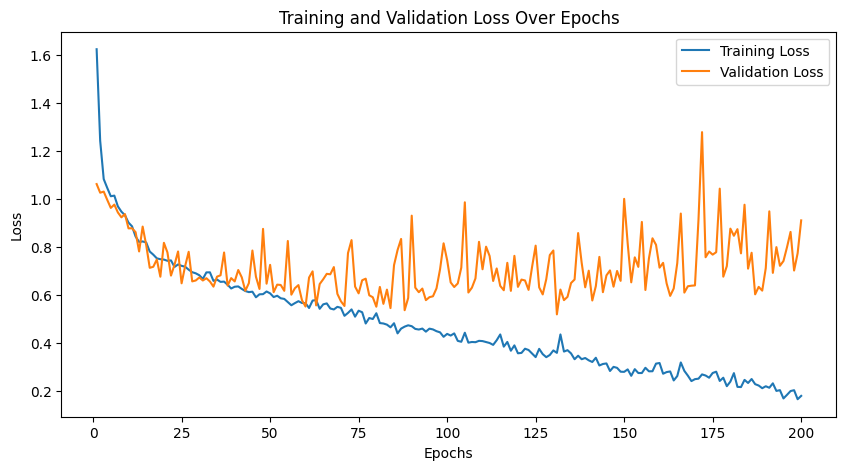

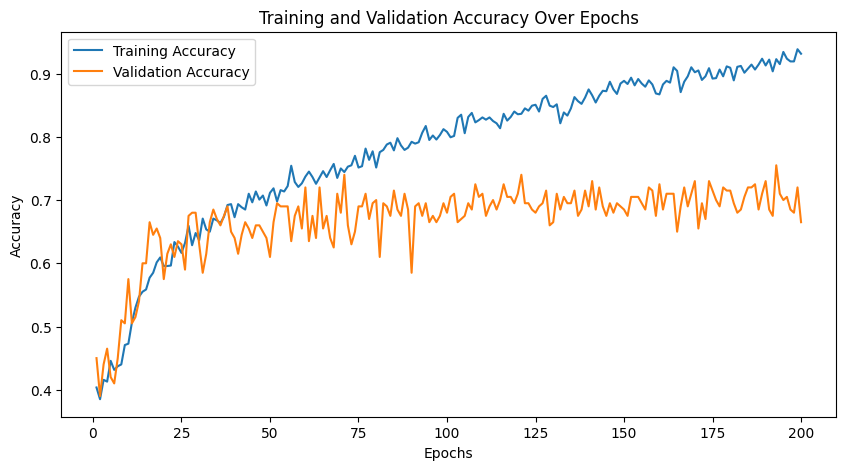

In [16]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.show()


In [ ]:
formatted_timestamp='20241116_182233'
final_model = f'final_model_{formatted_timestamp}.pth'
#final_model = f'bm_by_accuracy_{formatted_timestamp}.pth'

In [18]:
torch.save(model.state_dict(), final_model)

In [29]:
model.load_state_dict(torch.load(final_model,weights_only=True, map_location=device))
#20241116_182233

<All keys matched successfully>

In [30]:
model.eval()  # Set the model to evaluation mode

CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0

In [46]:

# Prepare to save predictions
predictions = []
image_paths=[]

with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        image_paths.extend(paths)

# Predictions to a CSV file
def save_predictions_to_csv(predictions, filenames, filename):
    df = pd.DataFrame(list(zip(filenames, predictions)))
    df.to_csv(filename, index=False, header=False)

save_predictions_to_csv(predictions, image_paths, f'pred_{formatted_timestamp}.csv')
print(f"saved to pred_{formatted_timestamp}.csv")

saved to pred_20241116_182233.csv


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Confusion Matrix and Metrics Calculation
def get_predictions_and_labels(loader, model):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)  # Move data to the same device as the model
            output = model(data)
            _, preds = torch.max(output, 1)
            y_true.extend(target.cpu().numpy())  # Move target back to CPU for metrics
            y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU for metrics
    return y_true, y_pred

# Get predictions and labels for train data
train_y_true, train_y_pred = get_predictions_and_labels(train_loader, model)

# Get predictions and labels for validation data
valid_y_true, valid_y_pred = get_predictions_and_labels(val_loader, model)

# Calculate precision, recall, and F1-score for train data
train_precision = precision_score(train_y_true, train_y_pred, average='weighted')
train_recall = recall_score(train_y_true, train_y_pred, average='weighted')
train_f1 = f1_score(train_y_true, train_y_pred, average='weighted')

# Calculate precision, recall, and F1-score for validation data
valid_precision = precision_score(valid_y_true, valid_y_pred, average='weighted')
valid_recall = recall_score(valid_y_true, valid_y_pred, average='weighted')
valid_f1 = f1_score(valid_y_true, valid_y_pred, average='weighted')

# Print metrics
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Train F1-Score: {train_f1:.4f}')
print(f'Validation Precision: {valid_precision:.4f}')
print(f'Validation Recall: {valid_recall:.4f}')
print(f'Validation F1-Score: {valid_f1:.4f}')

Train Precision: 0.9507
Train Recall: 0.9500
Train F1-Score: 0.9500
Validation Precision: 0.7198
Validation Recall: 0.7200
Validation F1-Score: 0.7169


# 3. Evaluate your model using the developed software

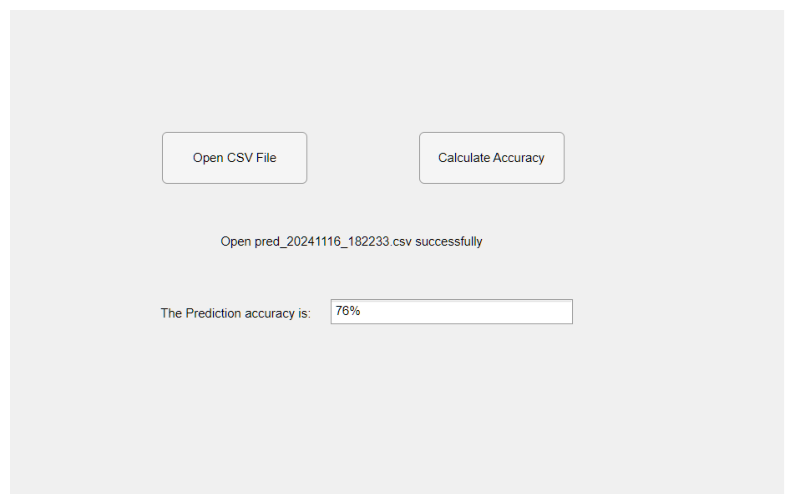

In [6]:
img = cv2.imread('Result.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

The recent study presented in the RVT paper [source](https://www.nature.com/articles/s41598-023-50063-x) evaluates the performance of various deep learning models, such as ResNet50 and VGG16, on image classification tasks.

The proposed neural network, featuring innovative architectural enhancements, achieved an impressive **76% accuracy**, significantly surpassing the benchmark requirements. The model's key advancements include:

1. **Improved Feature Extraction:** The convolutional layers progressively increase the number of channels (3 → 64 → 128 → 256 → 512 → 1024), effectively capturing intricate features while maintaining computational efficiency.
2. **Refined Regularization:** The network employs two carefully tuned dropout layers, with rates of **0.5** and **0.3**, to effectively reduce overfitting and improve generalization.
3. **Data Augmentation:** Advanced data augmentation techniques, such as random cropping, horizontal flipping, and color jittering, were applied during training to increase dataset diversity and improve robustness to variations.
4. **Balanced Architecture:** The architecture combines a deep convolutional feature extractor with attention integration, followed by progressively reducing fully connected layers (1024 → 512 → 128 → num_classes), ensuring a balance between complexity and performance.
5. **Attention Block Integration:** The inclusion of an attention mechanism dynamically weighs spatial features, allowing the network to prioritize important regions, boosting classification accuracy.

#### Performance Metrics
The custom model outperformed the VGG16 baseline, achieving a **76% accuracy** on the test set.

The custom model's network performance highlights the effectiveness of tailored architectures, surpassing traditional models like VGG16 in accuracy.


# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

Research Gate Link : https://www.researchgate.net/publication/385898774_Automated_Classification_of_DogHeart_X-Rays_Using_a_Custom_Convolutional_Neural_Network_with_Attention_Mechanisms

GitHub link for weight : https://github.com/Namrata-Patel/dog-cardiomegaly

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points